In [12]:
pip install -U plotly kaleido


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [70]:
from modelnet10 import ModelNetClass, DatasetType, ModelNet
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import font_manager
from cycler import cycler
from sklearn.decomposition import PCA
import numpy as np
import open3d as o3d
import torch
import plotly.graph_objects as go

In [14]:
sns.set_theme()
sns.set_palette("Set2")

# plt.rcParams["axes.prop_cycle"] = cycler(alpha=[0])
fp = font_manager.FontProperties(fname="plots/FiraSans-Regular.ttf")
font_manager.fontManager.addfont("plots/FiraSans-Regular.ttf")
plt.rcParams["font.family"] = fp.get_name()

In [15]:
classes = [enum for enum in ModelNetClass]

def class_mapping(i):
    return classes[i].label

In [16]:
data = {
    "label": list(),
    "train_freq": list(),
    "test_freq": list()
}
    
for label in classes:
    data["label"].append(label.label)
    data["train_freq"].append(label.train_size)
    data["test_freq"].append(label.test_size)
    

df = pd.DataFrame(data = data)
df

,label,train_freq,test_freq
0,bathtub,106,50
1,bed,515,100
2,chair,889,100
3,desk,200,86
4,dresser,200,86
5,monitor,465,100
6,night_stand,200,86
7,sofa,680,100
8,table,392,100
9,toilet,344,100


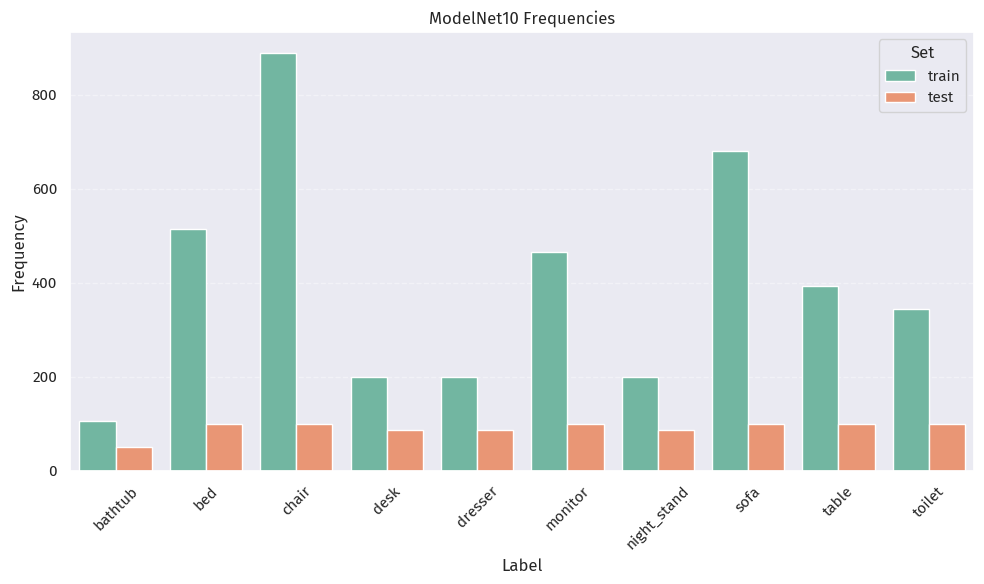

In [17]:
# Melt into long-form
df_long = df.melt(id_vars='label', var_name='split', value_name='freq')
# Renaming columns to match intent
df_long['set'] = df_long['split'].str.replace('_freq', '')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='label', y='freq', hue='set')

plt.title("ModelNet10 Frequencies")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Set')

plt.savefig("modelnet10_freq.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

plt.show()    

In [46]:
dataset_train = ModelNet(classes, DatasetType.TRAIN)
dataset_valid = ModelNet(classes, DatasetType.VALIDATION)
dataset_test = ModelNet(classes, DatasetType.TEST)
X_train = torch.transpose(dataset_train._X, 1, 2)
y_train = dataset_train._y

X_valid = torch.transpose(dataset_valid._X, 1, 2)
y_valid = dataset_valid._y

X_test = torch.transpose(dataset_test._X, 1, 2)

X_train = torch.cat((X_train, X_valid), dim=0)
y_train = torch.cat((y_train, y_valid), dim=0)

In [42]:
order_corners = [
    {"l", "f", "bo"},   # 0
    {"r", "f", "bo"},   # 1
    {"l", "ba", "bo"},  # 2
    {"l", "f", "t"},    # 3
    {"r", "ba", "t"},   # 4
    {"l", "ba", "t"},   # 5
    {"r", "f", "t"},    # 6
    {"r", "ba", "bo"},  # 7
]

edges = []
for i in range(len(order_corners)):
    for j in range(i + 1, len(order_corners)):
        if len(order_corners[i].intersection(order_corners[j])) == 2:
            edges.append((i, j))



def plot_bounding_boxes_from_tensor(pcd_tensor: torch.Tensor, filename, color):
    """
    Input:
        pcd_tensor: torch.Tensor of shape (B, N, 3)
    Output:
        Interactive 3D Plotly figure with all OBBs
    """
    assert pcd_tensor.ndim == 3 and pcd_tensor.shape[2] == 3, "Expected shape (B, N, 3)"

    fig = go.Figure()

    for i in range(pcd_tensor.shape[0]):
        points = pcd_tensor[i].cpu().numpy()

        # Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        obb = pcd.get_axis_aligned_bounding_box()
        corners = np.asarray(obb.get_box_points())  # shape (8, 3)
        
        
        # Generate line coordinates
        x_lines, y_lines, z_lines = [], [], []
        for i0, i1 in edges:
            x_lines.extend([corners[i0, 0], corners[i1, 0], None])
            y_lines.extend([corners[i0, 1], corners[i1, 1], None])
            z_lines.extend([corners[i0, 2], corners[i1, 2], None])

        fig.add_trace(go.Scatter3d(
            x=x_lines, y=y_lines, z=z_lines,
            mode='lines',
            line=dict(color=color, width=4),
            name=f'OBB {i}'
        ))

    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=10, r=10, t=10, b=10),  # minimal margins in pixels
        autosize=True,
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
            aspectmode='data'
        ),
        showlegend=False
    )
    
    #fig.show()

    # Export as PDF
    fig.write_image(filename, format="png")


def plot_mean_aabb(pcd_tensor: torch.Tensor, filename, color):
    min_bounds, max_bounds = [], []

    for i in range(pcd_tensor.shape[0]):
        points = pcd_tensor[i].cpu().numpy()
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        aabb = pcd.get_axis_aligned_bounding_box()
        min_bounds.append(np.asarray(aabb.get_min_bound()))
        max_bounds.append(np.asarray(aabb.get_max_bound()))

    mean_min = np.mean(min_bounds, axis=0)
    mean_max = np.mean(max_bounds, axis=0)

    # Reconstruct AABB from averaged bounds
    mean_aabb = o3d.geometry.AxisAlignedBoundingBox(min_bound=mean_min, max_bound=mean_max)
    corners = np.asarray(mean_aabb.get_box_points())

    x_lines, y_lines, z_lines = [], [], []
    for i0, i1 in edges:
        x_lines.extend([corners[i0, 0], corners[i1, 0], None])
        y_lines.extend([corners[i0, 1], corners[i1, 1], None])
        z_lines.extend([corners[i0, 2], corners[i1, 2], None])

    fig = go.Figure(data=[
        go.Scatter3d(
            x=x_lines, y=y_lines, z=z_lines,
            mode='lines',
            line=dict(color=color, width=6),
            name='Mean AABB'
        )
    ])

    fig.update_layout(
        margin=dict(l=10, r=10, t=10, b=10),  # minimal margins in pixels
        autosize=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
            aspectmode='data'
        ),
        showlegend=False
    )

    fig.write_image(filename, format="png")


plot_bounding_boxes_from_tensor(X_train, "plots/bboxes_train.png", "#71b6a1") 
plot_mean_aabb(X_train, "plots/mean_bbox_train.png", "#71b6a1")
plot_bounding_boxes_from_tensor(X_test, "plots/bboxes_test.png", "#e99575")  
plot_mean_aabb(X_train, "plots/mean_bbox_test.png", "#e99575")


In [63]:
def plot_pcd(pcd_tensor: torch.Tensor, filename, label):
    points = pcd_tensor.cpu().numpy()

    centered_label = f"&nbsp;&nbsp;&nbsp;{label}&nbsp;&nbsp;&nbsp;"
    
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color='royalblue', opacity=0.8),
                name=centered_label,
                showlegend=True  # Explicitly enable legend
            )
        ]
    )

    fig.update_layout(
        legend=dict(
            x=0.5,
            xanchor='center',
            y=0.95,
            bgcolor='rgba(255,255,255,0.6)',
            bordercolor='black',
            borderwidth=1,
            font=dict(size=12)
        ),
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
            aspectmode='data'
        ),
        showlegend=True
    )
    
    fig.write_image(filename, format="png")

filenames = list()
for i, label in enumerate(classes):
    train_idxs = np.argwhere(y_train == i)
    random_idx = np.random.choice(train_idxs[0])
    pcd = X_train[random_idx]
    filename = "plots/" + label.label + ".png"
    filenames.append(filename)
    plot_pcd(pcd, filename, label.label)

#toilets = np.where(arr)[0]

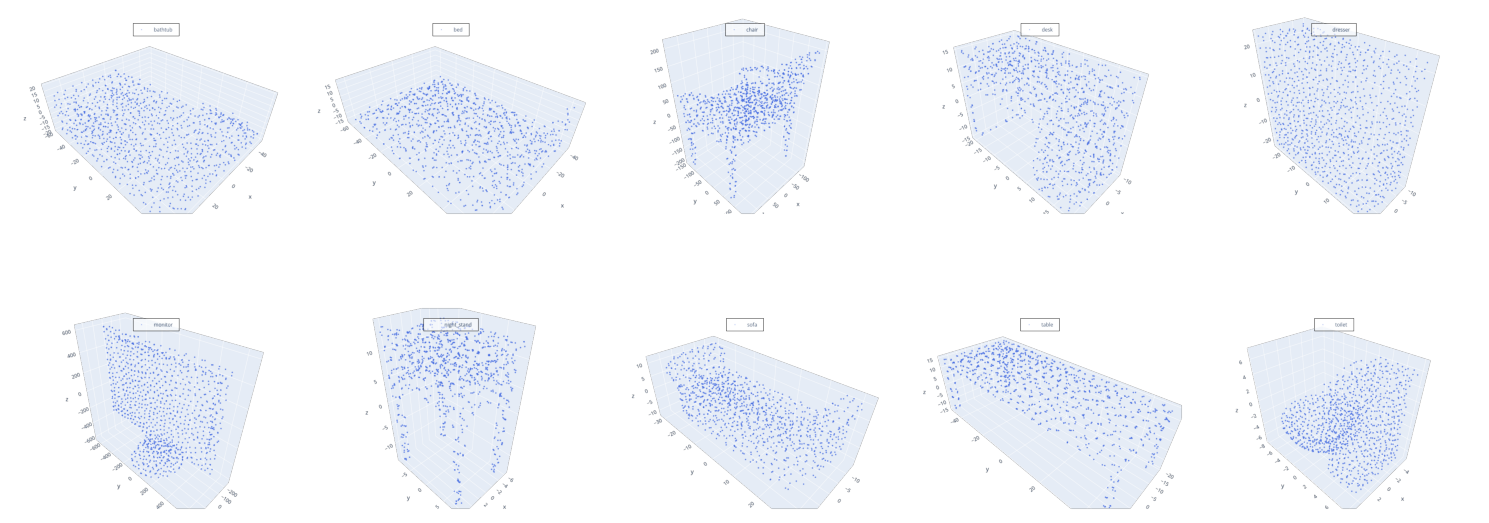

In [81]:
import math

def arrange_png_grid(image_files, images_per_row=5, image_size=3.0, spacing=0.01):
    num_images = len(image_files)
    num_rows = math.ceil(num_images / images_per_row)

    # Define figure size
    fig_width = images_per_row * image_size
    fig_height = num_rows * image_size
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(fig_width, fig_height))

    # Flatten axes for easy 1D indexing
    axes = axes.flatten() if num_rows > 1 or images_per_row > 1 else [axes]

    for i, image_file in enumerate(image_files):
        img = mpimg.imread(image_file)
        axes[i].imshow(img)
        axes[i].axis("off")

    # Remove extra unused axes
    for j in range(num_images, len(axes)):
        axes[j].remove()

    # Minimize vertical and horizontal space
    fig.subplots_adjust(
        left=spacing, right=1-spacing,
        top=1-spacing, bottom=spacing,
        wspace=spacing, hspace=spacing
    )

    plt.savefig("plots/collage.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))



# Example usage:
arrange_png_grid(filenames, images_per_row=5)